In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from rich.progress import track
from tqdm import tqdm, trange
# from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
# from torch.utils import tensorboard
import tensorboardX
import random
from matplotlib import pyplot as plt

In [4]:
train_name = []
test_name = []
for f in os.scandir('./project/InitialAIG/train'):
    train_name.append(f.name.split('.')[0])
for f in os.scandir('./project/InitialAIG/test'):
    test_name.append(f.name.split('.')[0])
print(train_name, test_name, sep='\n')
print(len(train_name), len(test_name))

['adder', 'alu2', 'apex3', 'apex5', 'arbiter', 'b2', 'c1355', 'c2670', 'c5315', 'c6288', 'ctrl', 'frg1', 'i7', 'i8', 'int2float', 'log2', 'm3', 'max', 'max512', 'multiplier', 'priority', 'prom2', 'table5']
['alu4', 'apex1', 'apex2', 'apex4', 'b9', 'bar', 'c7552', 'c880', 'cavlc', 'div', 'i9', 'm4', 'max1024', 'mem_ctrl', 'pair', 'prom1', 'router', 'sqrt', 'square', 'voter']
23 20


In [6]:
print(data[0])

{'x': tensor([[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [2, 2],
        [1, 1],
        [2, 2]]), 'edge_index': tensor([[ 257,  258,  259,  ..., 1277, 1278, 1278],
        [ 388,  394,  402,  ..., 1276, 1272, 1276]]), 'y': tensor(0.1595)}


In [3]:
data = []
for name in train_name:
    file_path = f'./train_data_tensor_{name}.pkl'
    if not os.path.exists(file_path):
        print(f'{name} not found')
        os._exit(1)
    data += pickle.load(open(file_path, "rb"))
print(len(data))
pickle.dump(data, open("train_data_tensor.pkl", "wb"))

89056


In [2]:
data = pickle.load(open("train_data_tensor.pkl", "rb"))
len(data)

89056

In [6]:
data[0]

{'x': tensor([[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [2, 2],
         [1, 1],
         [2, 2]]),
 'edge_index': tensor([[ 257,  258,  259,  ..., 1277, 1278, 1278],
         [ 388,  394,  402,  ..., 1276, 1272, 1276]]),
 'y': tensor(0.1595)}

In [3]:
# print(len(data))
random.shuffle(data)
train_ratio = 0.7
train_size = int(train_ratio * len(data))
train_data = data[:train_size]
test_data = data[train_size:]
print(len(train_data), len(test_data))

62339 26717


In [4]:
class AIGDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.length = len(data)
    def __len__(self):
        return self.length
    def __getitem__(self, idx):
        return Data(x=self.data[idx]['x'], edge_index=self.data[idx]['edge_index'], y=self.data[idx]['y']).cuda()

In [57]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, output_dim, hidden_dim, ratio):
        super(GCN, self).__init__()
        self.num_node_features = num_node_features
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.ratio = ratio
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        # self.conv3 = GCNConv(hidden_dim * ratio, hidden_dim * ratio)
        # self.conv4 = GCNConv(hidden_dim * ratio, hidden_dim * ratio)
        # self.conv5 = GCNConv(hidden_dim * ratio, hidden_dim)
        # self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
    def forward(self, x, edge_index, batch):
        # print(x.dtype, edge_index.dtype, batch.dtype)
        # print(x.shape, edge_index.shape, batch.shape)
        x = F.relu(self.conv1(x, edge_index))
        # print(x.dtype)
        x = F.relu(self.conv2(x, edge_index))
        # x = F.relu(self.conv3(x, edge_index))
        # x = F.relu(self.conv4(x, edge_index))
        # x = F.relu(self.conv5(x, edge_index))
        x = global_mean_pool(x, batch)
        # x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [61]:
from torch_geometric.nn.models import GCN

class GCN_(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, dropout, num_layers):
        super(GCN_, self).__init__()
        self.gcn = GCN(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=hidden_channels, dropout=dropout, num_layers=num_layers)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)
        
    def forward(self, x, edge_index, batch):
        x = self.gcn(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

gcn = GCN_(in_channels=-1, hidden_channels=16, out_channels=1, dropout=0., num_layers=4).cuda()
# optimizer = torch.optim.Adam(gcn.parameters(), lr=0.1, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss(reduction='sum')
dataset = AIGDataset(train_data)
dataloader = DataLoader(dataset,batch_size=64, shuffle=True)

100%|██████████| 488/488 [01:02<00:00,  7.78it/s]


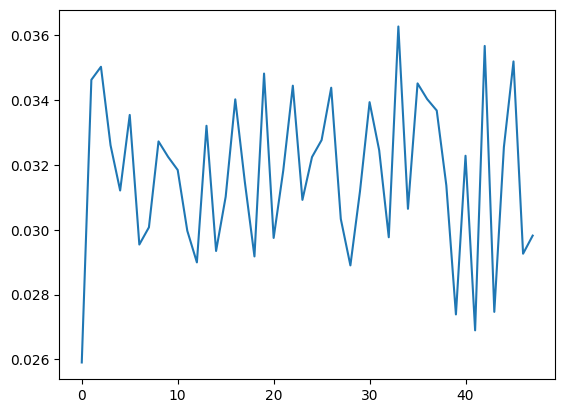

In [98]:
dataloader = DataLoader(dataset,batch_size=128, shuffle=True)
# optimizer = torch.optim.SGD(gcn.parameters(), lr=0.01, momentum=0.)
epochs = 1
optimizer = torch.optim.AdamW(gcn.parameters(), lr=0.0001, weight_decay=5e-4)
gcn.train()
losses = []
tmp = 0
i = 0
for e in range(epochs):
    for d in tqdm(dataloader):
        optimizer.zero_grad()
        # print(d.x.shape, d.y.shape, d.edge_index.shape, d.batch.shape)
        out =gcn(d.x.to(dtype=torch.float32), d.edge_index, d.batch)
        # print(out.shape, d.y.shape)
        loss = F.mse_loss(out.squeeze(1), d.y)
        loss.backward()
        optimizer.step()
        tmp += loss.item()
        # losses.append(loss.item())
        if i % 10 == 9:
            losses.append(tmp / 10)
            tmp = 0
        i += 1
plt.plot(losses)
# plt.ylim(0, 0.05)
plt.show()

In [5]:
from torch_geometric.nn.models import GraphSAGE

class GraphSAGE_(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout, num_layers):
        super(GraphSAGE_, self).__init__()
        self.sage = GraphSAGE(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=hidden_channels, dropout=dropout, num_layers=num_layers)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)
        
    def forward(self, x, edge_index, batch):
        x = self.sage(x, edge_index, batch)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

sage = GraphSAGE_(in_channels=-1, hidden_channels=128, out_channels=1, dropout=0., num_layers=8).cuda()

100%|██████████| 488/488 [47:26<00:00,  5.83s/it] 


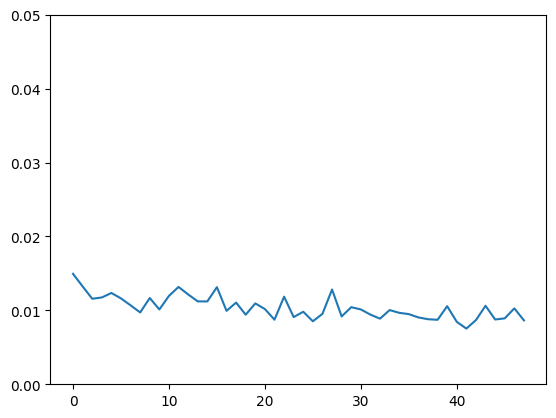

In [9]:
sage = torch.load('sage128.pth')
# print(len(losses))
loss_fn = torch.nn.MSELoss(reduction='sum')
dataset = AIGDataset(train_data)
# dataloader = DataLoader(dataset,batch_size=64, shuffle=True)
dataloader = DataLoader(dataset,batch_size=128, shuffle=True)
# optimizer = torch.optim.SGD(gcn.parameters(), lr=0.0005, momentum=0.9)
# optimizer = torch.optim.Adam(gcn.parameters(), lr=0.1, weight_decay=5e-4)
optimizer = torch.optim.AdamW(sage.parameters(), lr=0.001, weight_decay=5e-4)
epochs = 1
sage.train()
losses = []
i = 0
tmp = 0
for e in range(epochs):
    for d in tqdm(dataloader):
        optimizer.zero_grad()
        # print(d.x.shape, d.y.shape, d.edge_index.shape, d.batch.shape)
        out =sage(d.x.to(dtype=torch.float32), d.edge_index, d.batch)
        # print(out.shape, d.y.shape)
        # loss = loss_fn(out.squeeze(1), d.y)
        loss = F.mse_loss(out.squeeze(1), d.y)
        loss.backward()
        optimizer.step()
        # losses.append(loss.item())
        tmp += loss.item()
        if i % 10 == 9:
            losses.append(tmp / 10)
            tmp = 0
        i += 1
plt.plot(losses)
plt.ylim(0, 0.05)
plt.show()

In [10]:
sage = torch.load('sage128.pth')
print(sage)
test_dataloader = DataLoader(AIGDataset(test_data),batch_size=128, shuffle=False)
sage.eval()
test_losses = []
with torch.no_grad():
    for d in tqdm(test_dataloader):
        out =sage(d.x.to(dtype=torch.float32), d.edge_index, d.batch)
        # print(out.shape, d.y.shape)
        # loss = loss_fn(out.squeeze(1), d.y)
        loss = F.mse_loss(out.squeeze(1), d.y)
        test_losses.append(loss.item())
        
print(np.mean(test_losses))

GraphSAGE_(
  (sage): GraphSAGE(-1, 128, num_layers=8)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


 57%|█████▋    | 119/209 [05:41<04:21,  2.91s/it]

In [103]:
torch.save(sage, 'sage128.pth')

100%|██████████| 488/488 [00:42<00:00, 11.42it/s]


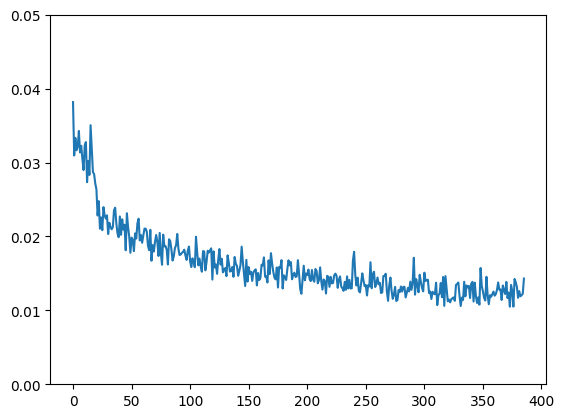

In [78]:
print(losses[-1])

In [94]:
from torch_geometric.nn.models import GAT

class GAT_(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout, num_layers):
        super(GAT_, self).__init__()
        self.gat = GAT(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=hidden_channels, dropout=dropout, num_layers=num_layers)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)
        
    def forward(self, x, edge_index, batch):
        x = self.gat(x, edge_index, batch)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

gat = GAT_(in_channels=-1, hidden_channels=16, out_channels=1, dropout=0., num_layers=4).cuda()

100%|██████████| 488/488 [00:57<00:00,  8.50it/s]


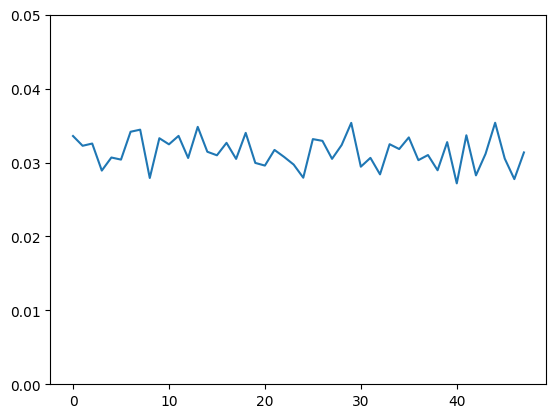

In [95]:
loss_fn = torch.nn.MSELoss(reduction='sum')
dataset = AIGDataset(train_data)
# dataloader = DataLoader(dataset,batch_size=64, shuffle=True)
dataloader = DataLoader(dataset,batch_size=128, shuffle=True)
# optimizer = torch.optim.SGD(gcn.parameters(), lr=0.0005, momentum=0.9)
# optimizer = torch.optim.Adam(gcn.parameters(), lr=0.1, weight_decay=5e-4)
optimizer = torch.optim.AdamW(gat.parameters(), lr=0.0005, weight_decay=5e-4)
epochs = 1
gat.train()
losses = []
i = 0
tmp = 0
for e in range(epochs):
    for d in tqdm(dataloader):
        optimizer.zero_grad()
        # print(d.x.shape, d.y.shape, d.edge_index.shape, d.batch.shape)
        out =gat(d.x.to(dtype=torch.float32), d.edge_index, d.batch)
        # print(out.shape, d.y.shape)
        # loss = loss_fn(out.squeeze(1), d.y)
        loss = F.mse_loss(out.squeeze(1), d.y)
        loss.backward()
        optimizer.step()
        # losses.append(loss.item())
        tmp += loss.item()
        if i % 10 == 9:
            losses.append(tmp / 10)
            tmp = 0
        i += 1
plt.plot(losses)
plt.ylim(0, 0.05)
plt.show()

In [66]:
num_node_features = 2
output_dim = 1
hidden_dim = 16
ratio = 4
dataset = AIGDataset(train_data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device('cuda')
model = GCN(num_node_features=num_node_features, output_dim=output_dim, hidden_dim=hidden_dim, ratio=ratio).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [69]:
writer = tensorboardX.SummaryWriter(logdir='./runs4')
epochs = 1
model.train()
# progress = tqdm(dataloader)
i = 0
for e in range(epochs):
    for d in tqdm(dataloader):
        optimizer.zero_grad()
        out = model(d.x.to(dtype=torch.float32), d.edge_index, d.batch)
        # print(out.squeeze(1).shape, d.y.shape)
        loss = F.mse_loss(out.squeeze(1), d.y)
        writer.add_scalar('Loss/train', loss, i)
        i += 1
        loss.backward()
        optimizer.step()

100%|██████████| 975/975 [00:30<00:00, 31.71it/s]


In [60]:
torch.save(model, 'model_task1_2.pth')